### The Kelly Rule - Size Positions for a Portfolio

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
%matplotlib inline
from pathlib import Path

import numpy as np
from numpy.linalg import inv
from numpy.random import dirichlet
import pandas as pd

from sympy import symbols, solve, log, diff, nonlinsolve
from scipy.optimize import minimize_scalar, newton, minimize
from scipy.integrate import quad
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

import pytz
from datetime import datetime as dt
from histData import binance_bars
from utils.tools import to_utc, multiJoin, multiDF
from utils.flow import Kalman
from tqdm.notebook import tqdm, trange
from utils.analysis import Security, join_dfs
from pyomo.environ import *

In [8]:
sns.set_style('whitegrid')
np.random.seed(42)

### Kelly - allow Leverge & Shorts

In [9]:
def buildLevKCOptModel(returns: np.array, varcov: np.matrix, 
                    rfr: float = 0, lam_max: float = 3):

  m = ConcreteModel()

  # Indices
  m.i = RangeSet(0, returns.shape[0] - 1)

  # Decision variables
  m.f = Var(m.i, domain=Reals)
  m.x = Var(m.i, domain=Reals)

  # Parameters
  m.mu = Param(m.i, 
               initialize={i: m for i, m in zip(m.i, returns)})
  m.sigma = Param(m.i, m.i, 
                  initialize={(i, j): varcov[i, j] 
                              for i in m.i 
                              for j in m.i})
  m.lam_max = lam_max

  # Constraints
  @m.Constraint()
  def maxLeverageConstraint(m):
    return sum(m.x[i] for i in m.i) <= m.lam_max

  @m.Constraint(m.i)
  def posFraction(m, i):
    return m.x[i] - m.f[i] >= 0

  @m.Constraint(m.i)
  def negFraction(m, i):
    return m.x[i] + m.f[i] >= 0

  Objective
  @m.Objective(sense=maximize)
  def objective(m):
    return (rfr + sum(m.f[i] * (m.mu[i] - rfr) for i in m.i) - \
            sum(
                sum(m.f[i] * m.sigma[i, j] * m.f[j] for j in m.i)
            for i in m.i) / 2)

  return m

In [10]:
# model = buildKCOptModel(mu, varcov)

tickers=['BTCUSDT', 'ETHUSDT', 'SOLUSDT']
interval='1d'
start_dt='2021-01-01'
end_dt=None
vol_window=22
kel_window=22
kel_bounds = [0., 1.]
bounds = np.array(kel_bounds)
annualize = True
start_dt = to_utc(start_dt)
end_dt = pytz.utc.localize(dt.utcnow()) if not end_dt else to_utc(end_dt)
print ("START DATE:", start_dt)
print("END DATE:", end_dt)
print("TICKERS:", tickers)
print("INTERVAL:", interval)

Assuming naive datetime: 2021-01-01 00:00:00 is already in UTC and labelling it as such. Ensure this is correct.
START DATE: 2021-01-01 00:00:00+00:00
END DATE: 2022-06-23 16:34:15.232810+00:00
TICKERS: ['BTCUSDT', 'ETHUSDT', 'SOLUSDT']
INTERVAL: 1d


In [11]:
class OptimalAllocation:
  def __init__(self, tickers: list, interval='1d', max_leverage: float=2, 
    lookback: int=22, rfr: float=0, 
    start_dt: str='2021-01-01', end_dt=None,
    rebalance_freq: int=1,
    annualize = True):
    
    self.sets = dict()
    self.tickers = tickers
    self.start_dt = to_utc(start_dt)
    self.end_dt = pytz.utc.localize(dt.utcnow()) if not end_dt else to_utc(end_dt)
    self.interval = interval
    self.max_leverage = max_leverage
    self.lookback = lookback
    self.rfr = rfr
    self.rebalance_freq = rebalance_freq
    self.annualize = annualize
    print ("START DATE:", start_dt)
    print("END DATE:", end_dt)
    print("TICKERS:", tickers)
    print("INTERVAL:", interval)
    
    self.data = self._getData()
    self._calcStats()

  def _getData(self):
    for ticker in self.tickers:
      df = binance_bars(symbol=ticker, interval=self.interval,
                          start_dt=self.start_dt, end_dt=self.end_dt, limit=None, dtype='df');
      self.sets[ticker] = df

    data = multiJoin(dfs = [pd.DataFrame(df['close']) for df in self.sets.values()], method = 'outer', names = list(self.sets.keys()))
    data = multiDF(data, sep = '_', level1 = 'Ticker', level2 = 'Series')
    data.dropna(inplace=True)
    return data

  def _calcStats(self):
    # Calc returns
    returns = self.data.loc[:, (slice(None), "close")] / \
      self.data.loc[:, (slice(None), "close")].shift(1) -1
    returns = returns.rename(columns={"close": "returns"})
    
    means = returns.rolling(self.lookback).mean().rename(
        columns={"returns": "mean"})
    # Calculate covariance matrices and transform to 3D array
    n = returns.shape[1]
    self.cov = returns.droplevel(1, axis=1).rolling(
        self.lookback).cov().values.reshape(-1, n, n)
    self.data = pd.concat([self.data, returns, means], axis=1)
    
  def calcKCUnconstrainedAllocation(self):
    '''
    Calculates the allocation fractions for the unconstrained 
    Kelly Criterion case.
    '''
    fracs = np.zeros((len(self.data), len(self.tickers)))
    fracs[:] = np.nan
    for i, (ts, row) in enumerate(self.data.iterrows()):
        if i < self.lookback:
          continue
        means = row.loc[(slice(None)), "mean"].values
    
        F = np.dot(means, np.linalg.inv(self.cov[i]))
        fracs[i] = F
    df_fracs = pd.DataFrame(fracs, index=self.data.index)
    midx = pd.MultiIndex.from_arrays(
        [self.tickers, len(self.tickers)*['unconstrained_fracs']])
    df_fracs.columns = midx
    return df_fracs

  def calcKCHeuristicAllocation(self, kelly_level: float=1):
    '''
    Calculates the allocation fractions using a simple max leverage 
    heuristic for the Kelly Criterion.
    kelly_level: allows setting to full kelly (1) half-kelly (0.5)
                 or any other multiple. This takes the solution and
                 scales it down accordingly to reduce actual 
                 leverage.
    '''
    df_fracs = self.calcKCUnconstrainedAllocation()
    heur_fracs = df_fracs.apply(
        lambda x: kelly_level * self.max_leverage * np.abs(x) / \
          np.abs(x).sum() * np.sign(x), 
        axis=1)
    heur_fracs = heur_fracs.rename(
        columns={'unconstrained_fracs': 'heuristic_fracs'})
    return heur_fracs
  
  def calcKcAllocation(self, kelly_level: float=1):
    '''
    Calculates optimal allocation fractions by solving a quadratic 
    program according to the Kelly Criterion.    
    
    kelly_level: allows setting to full kelly (1) half-kelly (0.5)
                 or any other multiple. This takes the solution from 
                 the QP and scales it down accordingly to reduce 
                 actual leverage.
    '''
    fracs = np.zeros((len(self.data), len(self.tickers)))
    fracs[:] = np.nan
    g = fracs[:, 0].copy()
    for i, (ts, row) in enumerate(self.data.iterrows()):
      if i < self.lookback:
        continue
      means = row.loc[(slice(None)), "mean"].values
      cov = self.cov[i]
      model = buildLevKCOptModel(means, cov, self.rfr,
              self.max_leverage)
      results = SolverFactory('ipopt').solve(model)
      fracs[i] = np.array([model.f[j].value * kelly_level
                           for j in model.f])
      g[i] = model.objective.expr()
    df_fracs = pd.DataFrame(fracs, index=self.data.index)
    midx = pd.MultiIndex.from_arrays(
        [self.tickers, len(self.tickers)*['qp_fracs']])
    df_fracs.columns = midx
    return df_fracs
    
  def calcEqualAllocation(self):
    '''
    Rebalance so that the portfolio maintains a constant, equal 
    allocation among each of the assets.
    '''
    fracs = np.ones((len(self.data), len(self.tickers))) / \
      len(self.tickers)
    fracs[:self.lookback] = np.nan
    df_fracs = pd.DataFrame(fracs, index=self.data.index)
    midx = pd.MultiIndex.from_arrays(
        [self.tickers, len(self.tickers)*['eq_fracs']])
    df_fracs.columns = midx
    return df_fracs

In [13]:
opt = OptimalAllocation(
    ["BTCUSDT", "ETHUSDT", "SOLUSDT"],
    interval="1d",
    max_leverage=2,
    lookback=22, # 22*60
    rfr=0,
    start_dt="2021-01-01",
    end_dt=None,
    rebalance_freq=1,
    annualize=True,
)

Assuming naive datetime: 2021-01-01 00:00:00 is already in UTC and labelling it as such. Ensure this is correct.
START DATE: 2021-01-01
END DATE: None
TICKERS: ['BTCUSDT', 'ETHUSDT', 'SOLUSDT']
INTERVAL: 1d
(539, 5)
(539, 5)
(539, 5)


In [14]:
# Calculate optimal allocations:
# uc_fracs = opt.calcKCUnconstrainedAllocation()
# heur_fracs = opt.calcKCHeuristicAllocation()
qp_fracs = opt.calcKcAllocation()
# eq_fracs = opt.calcEqualAllocation()

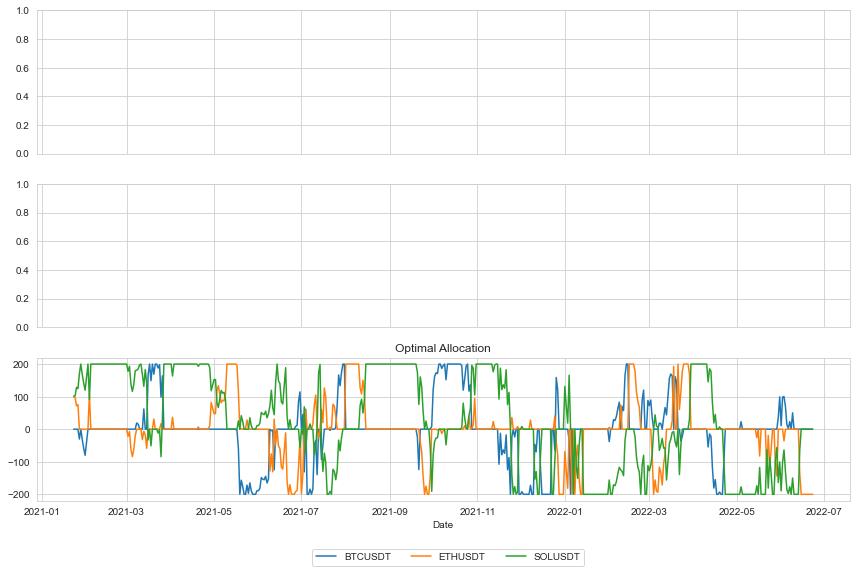

In [15]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
labels = opt.tickers

fig, ax = plt.subplots(3, figsize=(12, 8), sharex=True)

# ax[0].plot(uc_fracs * 100)
# ax[0].set_title('Unconstrained Allocation')
# ax[0].semilogy()

# ax[1].plot(heur_fracs * 100)
# ax[1].set_ylabel('Portfolio Allocation (%)')
# ax[1].set_title('Heuristic Allocation')

ax[2].plot(qp_fracs * 100)
ax[2].set_xlabel('Date')
ax[2].set_title('Optimal Allocation')
ax[2].legend(labels=labels, ncol=len(labels),
             bbox_to_anchor=(0.68, -0.3))

plt.tight_layout()
plt.show()

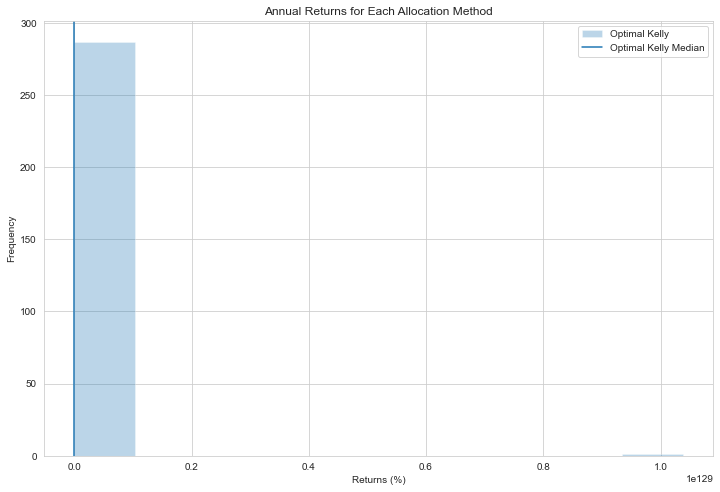

In [16]:
# NB - these lines of code are hardcoded for annualizig daily returns

log_rets = np.log(opt.data.loc[:, (slice(None), "returns")].values)
# heur_rets = log_rets * heur_fracs.shift(1)
# heur_log_rets_ann = heur_rets.sum(axis=1).rolling(252).sum().dropna()
# heur_rets_ann = (np.exp(heur_log_rets_ann) - 1) * 100
# eq_rets = log_rets * eq_fracs.shift(1) * opt.max_leverage
# eq_log_rets_ann = eq_rets.sum(axis=1).rolling(252).sum().dropna()
# eq_rets_ann = (np.exp(eq_log_rets_ann) - 1) * 100
qp_rets = log_rets * qp_fracs.shift(1)
qp_log_rets_ann = qp_rets.sum(axis=1).rolling(252).sum().dropna()
qp_rets_ann = (np.exp(qp_log_rets_ann) - 1) * 100
plt.figure(figsize=(12, 8))
plt.hist(qp_rets_ann, label="Optimal Kelly", alpha=0.3, bins=10)
plt.axvline(x=np.median(qp_rets_ann), label="Optimal Kelly Median",
            c=colors[0])
# plt.hist(heur_rets_ann, label="Heuristic Kelly", alpha=0.3, bins=10)
# plt.axvline(x=np.median(heur_rets_ann), label="Heuristic Kelly Median",
#             c=colors[1])
# plt.hist(eq_rets_ann, label="Equal Allocation", alpha=0.3, bins=10)
# plt.axvline(x=np.median(eq_rets_ann), label="Equal Allocation Median",
#             c=colors[2])
plt.xlabel('Returns (%)')
plt.ylabel('Frequency')
plt.title('Annual Returns for Each Allocation Method')
plt.legend()
plt.show()

In [17]:
df1 = opt.data.copy()
cols = list(df1.columns.get_level_values(0))
for c in cols:
    df1[c, 'kel_rets']=df1.loc[:, (c, 'returns')].mul(qp_fracs.loc[:, (c, 'qp_fracs')].shift(1))
    df1[c, 'cum_rets']=df1.loc[:, (c, 'returns')].dropna().iloc[0:].add(1).cumprod().sub(1)

df1['opt_rets'] = df1.loc[:, (slice(None), 'kel_rets')].sum(axis=1)
df1 = df1.assign(opt_cum_returns=df1['opt_rets'].iloc[0:].add(1).cumprod().sub(1))
df1 = df1.dropna()
df1

Ticker                      BTCUSDT  ETHUSDT  SOLUSDT   BTCUSDT   ETHUSDT  \
Series                        close    close    close   returns   returns   
DateTime                                                                    
2021-01-24 00:00:00+00:00  32259.90  1392.51   3.6278  0.005671  0.128818   
2021-01-25 00:00:00+00:00  32254.20  1317.88   3.7038 -0.000177 -0.053594   
2021-01-26 00:00:00+00:00  32467.77  1365.97   4.0410  0.006621  0.036490   
2021-01-27 00:00:00+00:00  30366.15  1239.03   3.6750 -0.064729 -0.092930   
2021-01-28 00:00:00+00:00  33364.86  1329.69   3.8100  0.098752  0.073170   
...                             ...      ...      ...       ...       ...   
2022-06-19 01:00:00+00:00  20574.00  1128.53  34.1900  0.084509  0.134053   
2022-06-20 01:00:00+00:00  20573.89  1128.24  35.2400 -0.000005 -0.000257   
2022-06-21 01:00:00+00:00  20723.52  1125.85  36.4200  0.007273 -0.002118   
2022-06-22 01:00:00+00:00  19987.99  1050.19  34.1200 -0.035493 -0.067203   
2022-06-23 01:00:00+00:00  20311.39  1093.19  37.1700  0.016180  0.040945   

Ticker                      SOLUSDT   BTCUSDT   ETHUSDT   SOLUSDT  \
Series                      returns      mean      mean      mean   
DateTime                                                            
2021-01-24 00:00:00+00:00  0.034180  0.001646  0.031069  0.040046   
2021-01-25 00:00:00+00:00  0.020949  0.000477  0.016677  0.031452   
2021-01-26 00:00:00+00:00  0.091042  0.002171  0.015402  0.029058   
2021-01-27 00:00:00+00:00 -0.090572 -0.003557  0.008640  0.030913   
2021-01-28 00:00:00+00:00  0.036735 -0.002844  0.007466  0.037251   
...                             ...       ...       ...       ...   
2022-06-19 01:00:00+00:00  0.067770 -0.014063 -0.018594 -0.008908   
2022-06-20 01:00:00+00:00  0.030711 -0.014747 -0.019149 -0.008262   
2022-06-21 01:00:00+00:00  0.033485 -0.017912 -0.023885 -0.009003   
2022-06-22 01:00:00+00:00 -0.063152 -0.019621 -0.025646 -0.010478   
2022-06-23 01:00:00+00:00  0.089390 -0.016034 -0.020884 -0.000794   

Ticker                          BTCUSDT                 ETHUSDT            \
Series                         kel_rets  cum_rets      kel_rets  cum_rets   
DateTime                                                                    
2021-01-24 00:00:00+00:00 -5.046902e-13  0.099831  1.270776e-01  0.910400   
2021-01-25 00:00:00+00:00  1.599325e-11  0.099637 -5.233684e-02  0.808015   
2021-01-26 00:00:00+00:00 -5.524649e-09  0.106918  2.607690e-02  0.873990   
2021-01-27 00:00:00+00:00  4.821156e-08  0.035268 -7.018431e-02  0.699839   
2021-01-28 00:00:00+00:00 -2.998536e-02  0.137502  2.588815e-07  0.824217   
...                                 ...       ...           ...       ...   
2022-06-19 01:00:00+00:00 -5.441996e-08 -0.298574 -2.681055e-01  0.548243   
2022-06-20 01:00:00+00:00  1.005673e-11 -0.298578  5.139418e-04  0.547845   
2022-06-21 01:00:00+00:00 -1.504203e-08 -0.293477  4.236678e-03  0.544567   
2022-06-22 01:00:00+00:00  2.350812e-08 -0.318553  1.344050e-01  0.440768   
2022-06-23 01:00:00+00:00 -1.101482e-08 -0.307527 -8.188988e-02  0.499760   

Ticker                          SOLUSDT             opt_rets opt_cum_returns  
Series                         kel_rets   cum_rets                            
DateTime                                                                      
2021-01-24 00:00:00+00:00  3.464178e-02   0.969383  0.161719        0.161719  
2021-01-25 00:00:00+00:00  2.144068e-02   1.010640 -0.030896        0.125827  
2021-01-26 00:00:00+00:00  1.170226e-01   1.193692  0.143099        0.286932  
2021-01-27 00:00:00+00:00 -1.127401e-01   0.995006 -0.182924        0.051521  
2021-01-28 00:00:00+00:00  6.231494e-02   1.068292  0.032330        0.085516  
...                                 ...        ...       ...             ...  
2022-06-19 01:00:00+00:00 -1.677858e-09  17.560339 -0.268106       14.282765  
2022-06-20 01:00:00+00:00  4.783408e-09  18.130340  0.000514       14.290619  
2022-0

In [18]:
df1 = opt.data.copy()
cols = list(df1.columns.get_level_values(0))
for c in cols:
    df1[c, 'kel_rets']=df1.loc[:, (c, 'returns')].mul(qp_fracs.loc[:, (c, 'qp_fracs')].shift(1))
    df1[c, 'cum_rets']=df1.loc[:, (c, 'returns')].dropna().iloc[0:].add(1).cumprod().sub(1)

df1['opt_rets'] = df1.loc[:, (slice(None), 'kel_rets')].sum(axis=1)
df1 = df1.assign(opt_cum_returns=df1['opt_rets'].iloc[0:].add(1).cumprod().sub(1))
df1 = df1.dropna()
df1

Ticker                      BTCUSDT  ETHUSDT  SOLUSDT   BTCUSDT   ETHUSDT  \
Series                        close    close    close   returns   returns   
DateTime                                                                    
2021-01-24 00:00:00+00:00  32259.90  1392.51   3.6278  0.005671  0.128818   
2021-01-25 00:00:00+00:00  32254.20  1317.88   3.7038 -0.000177 -0.053594   
2021-01-26 00:00:00+00:00  32467.77  1365.97   4.0410  0.006621  0.036490   
2021-01-27 00:00:00+00:00  30366.15  1239.03   3.6750 -0.064729 -0.092930   
2021-01-28 00:00:00+00:00  33364.86  1329.69   3.8100  0.098752  0.073170   
...                             ...      ...      ...       ...       ...   
2022-06-19 01:00:00+00:00  20574.00  1128.53  34.1900  0.084509  0.134053   
2022-06-20 01:00:00+00:00  20573.89  1128.24  35.2400 -0.000005 -0.000257   
2022-06-21 01:00:00+00:00  20723.52  1125.85  36.4200  0.007273 -0.002118   
2022-06-22 01:00:00+00:00  19987.99  1050.19  34.1200 -0.035493 -0.067203   
2022-06-23 01:00:00+00:00  20311.39  1093.19  37.1700  0.016180  0.040945   

Ticker                      SOLUSDT   BTCUSDT   ETHUSDT   SOLUSDT  \
Series                      returns      mean      mean      mean   
DateTime                                                            
2021-01-24 00:00:00+00:00  0.034180  0.001646  0.031069  0.040046   
2021-01-25 00:00:00+00:00  0.020949  0.000477  0.016677  0.031452   
2021-01-26 00:00:00+00:00  0.091042  0.002171  0.015402  0.029058   
2021-01-27 00:00:00+00:00 -0.090572 -0.003557  0.008640  0.030913   
2021-01-28 00:00:00+00:00  0.036735 -0.002844  0.007466  0.037251   
...                             ...       ...       ...       ...   
2022-06-19 01:00:00+00:00  0.067770 -0.014063 -0.018594 -0.008908   
2022-06-20 01:00:00+00:00  0.030711 -0.014747 -0.019149 -0.008262   
2022-06-21 01:00:00+00:00  0.033485 -0.017912 -0.023885 -0.009003   
2022-06-22 01:00:00+00:00 -0.063152 -0.019621 -0.025646 -0.010478   
2022-06-23 01:00:00+00:00  0.089390 -0.016034 -0.020884 -0.000794   

Ticker                          BTCUSDT                 ETHUSDT            \
Series                         kel_rets  cum_rets      kel_rets  cum_rets   
DateTime                                                                    
2021-01-24 00:00:00+00:00 -5.046902e-13  0.099831  1.270776e-01  0.910400   
2021-01-25 00:00:00+00:00  1.599325e-11  0.099637 -5.233684e-02  0.808015   
2021-01-26 00:00:00+00:00 -5.524649e-09  0.106918  2.607690e-02  0.873990   
2021-01-27 00:00:00+00:00  4.821156e-08  0.035268 -7.018431e-02  0.699839   
2021-01-28 00:00:00+00:00 -2.998536e-02  0.137502  2.588815e-07  0.824217   
...                                 ...       ...           ...       ...   
2022-06-19 01:00:00+00:00 -5.441996e-08 -0.298574 -2.681055e-01  0.548243   
2022-06-20 01:00:00+00:00  1.005673e-11 -0.298578  5.139418e-04  0.547845   
2022-06-21 01:00:00+00:00 -1.504203e-08 -0.293477  4.236678e-03  0.544567   
2022-06-22 01:00:00+00:00  2.350812e-08 -0.318553  1.344050e-01  0.440768   
2022-06-23 01:00:00+00:00 -1.101482e-08 -0.307527 -8.188988e-02  0.499760   

Ticker                          SOLUSDT             opt_rets opt_cum_returns  
Series                         kel_rets   cum_rets                            
DateTime                                                                      
2021-01-24 00:00:00+00:00  3.464178e-02   0.969383  0.161719        0.161719  
2021-01-25 00:00:00+00:00  2.144068e-02   1.010640 -0.030896        0.125827  
2021-01-26 00:00:00+00:00  1.170226e-01   1.193692  0.143099        0.286932  
2021-01-27 00:00:00+00:00 -1.127401e-01   0.995006 -0.182924        0.051521  
2021-01-28 00:00:00+00:00  6.231494e-02   1.068292  0.032330        0.085516  
...                                 ...        ...       ...             ...  
2022-06-19 01:00:00+00:00 -1.677858e-09  17.560339 -0.268106       14.282765  
2022-06-20 01:00:00+00:00  4.783408e-09  18.130340  0.000514       14.290619  
2022-0

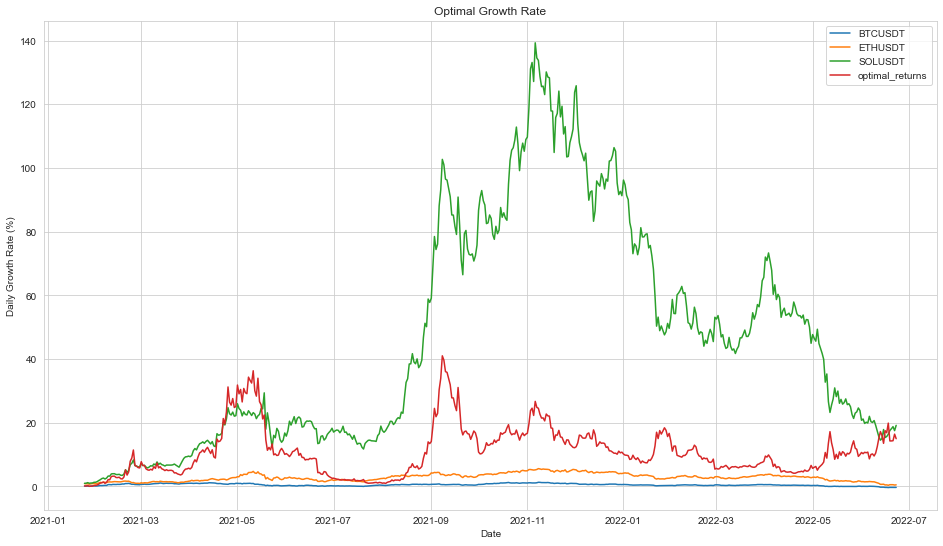

In [19]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
labels = [i for i in list(df1.columns.levels[0]) if i in tickers]
for l in labels:
    ax.plot(df1.loc[:, (l, 'cum_rets'),], label=l)
ax.plot(df1['opt_cum_returns'], label='optimal_returns')

ax.set_xlabel('Date')
ax.set_ylabel('Daily Growth Rate (%)')
ax.set_title('Optimal Growth Rate')

# labels.append('optimal_returns')
ax.legend()

In [20]:
df1.name = 'Optimal'
df1['time'] = df1.index.to_series()
opt_sec = Security(df1)
tot_ret = opt_sec.df['opt_cum_returns'][-1]
sharpe = opt_sec.get_geometric_sharpe(opt_sec.df['opt_rets'], ann_factor=365)
sortino = opt_sec.get_sortino(opt_sec.df['opt_rets'], required_return=0, rfr=0, ann_factor=365)
omega = opt_sec.get_omega(opt_sec.df['opt_rets'], rfr=0.0, req_return=0.0,
                  ann_factor=365)
print('TOTAL RETURN:', '{:,.2f}%'.format(tot_ret*100))
print('SHARPE:', '{:,.2f}'.format(sharpe))
print('SORTINO:', '{:,.2f}'.format(sortino))
print('OMEGA:', '{:,.2f}'.format(omega))

TOTAL RETURN: 1,499.28%
SHARPE: 0.82
SORTINO: 3.35
OMEGA: 1.34


In [21]:
qp_fracs

,BTCUSDT,ETHUSDT,SOLUSDT
,qp_fracs,qp_fracs,qp_fracs
DateTime,,,
2021-01-01 00:00:00+00:00,NaN,NaN,NaN
2021-01-02 00:00:00+00:00,NaN,NaN,NaN
2021-01-03 00:00:00+00:00,NaN,NaN,NaN
2021-01-04 00:00:00+00:00,NaN,NaN,NaN
2021-01-05 00:00:00+00:00,NaN,NaN,NaN
...,...,...,...
2022-06-19 01:00:00+00:00,-1.880974e-06,-1.999996,1.557569e-07
2022-06-20 01:00:00+00:00,-2.068255e-06,-1.999996,1.943536e-07
